In [2]:
import matplotlib.patches as patches
import matplotlib
import cv2
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from scipy import linalg



In [3]:


def cov(region, mu, r, c):
    indices = np.array(list(np.ndindex(region[:, :, 0].shape)))
    indices[:, 0] += r
    indices[0, :] += c
    # cv2 imread returns B, G, R (wtf?) so reverse it
    RGB = np.reshape(region[:, :, 2::-1], (-1, 3))
    # add indices and RGB next to eachother to get feature
    feature = np.hstack((indices, RGB))
    X = np.array(feature, ndmin=2, dtype=float)
    X -= mu[np.newaxis]
    return (np.divide(np.matmul(X.T, X), float(len(feature)))).squeeze()


modelCovMatrix = [[47.917, 0, -146.636, -141.572, -123.269],
                  [0, 408.250, 68.487, 69.828, 53.479],
                  [-146.636, 68.487, 2654.285, 2621.672, 2440.381],
                  [-141.572, 69.828, 2621.672, 2597.818, 2435.368],
                  [-123.269, 53.479, 2440.381, 2435.368, 2404.923]]

In [4]:
tgt = np.array(cv2.imread('target.jpg'))
limits = (tgt.shape[0]-70, tgt.shape[1]-24)
# make a list of all possible 70r, 24c regions
regions = np.array([tgt[r:r+70, c:c+24]
                   for r, c in np.ndindex(limits)])
# extract r, c from 3d array
indices = np.array(list(np.ndindex(tgt[:, :, 0].shape)))
# get the RGB values for the index
# cv2 imread returns B, G, R (wtf?) so reverse it
RGB = np.reshape(tgt[:, :, 2::-1], (-1, 3))
# combine the indices and RGB values
mu = np.hstack((indices, RGB)).mean(axis=0)

In [6]:
start = timer()
C = []
for r, c in np.ndindex(limits):
    C.append(cov(tgt[r:r+70, c:c+24], mu, r, c))
end = timer()
print(f'cov exec time: {end-start}')
pprint(C[0])

cov exec time: 104.262176702
array([[ 7633.25      , 12580.        ,  3292.54157366,  3285.3296503 ,
         3588.3875465 ],
       [12580.        , 21951.91666667,  5671.17909226,  5650.2596131 ,
         6206.50334077],
       [ 3292.54157366,  5671.17909226,  1853.5443587 ,  1847.84192598,
         1946.94179422],
       [ 3285.3296503 ,  5650.2596131 ,  1847.84192598,  1843.91166415,
         1941.51377895],
       [ 3588.3875465 ,  6206.50334077,  1946.94179422,  1941.51377895,
         2071.65810064]])


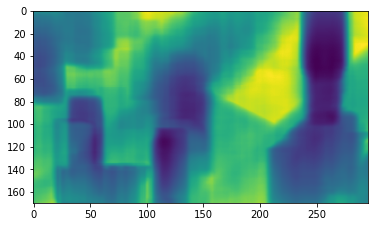

In [7]:
def manifold(model, cand):
    eig = linalg.eigh(model, cand, eigvals_only=True)
    return np.sqrt(np.sum(np.square(np.log2(eig, out=np.zeros_like(eig), where=(eig != 0)))))

# go through all pixels and calculate the manifold dist against the model
# ndindex iterates col first then row, so the indices will match up with the cov array
match_dist = np.zeros(limits)
for i, (r, c) in enumerate(np.ndindex(limits)):
    match_dist[r][c] = manifold(modelCovMatrix, C[i])
plt.imshow(match_dist)

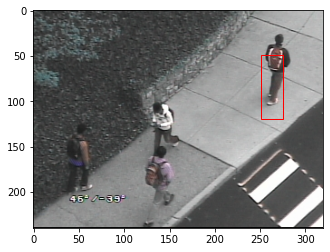

In [16]:

def show_k_matches(img, k):
    plt.imshow(img)
    ax = plt.gca()
    ax.imshow(img)
    for i in range(k):
        i_min = np.unravel_index(np.argpartition(
            match_dist, i, axis=None)[i], match_dist.shape)
        # print(C[temp])
        # print(match_dist[i_min])
        # print(i_min)
        # patches is x,y so need to flip
        rect = patches.Rectangle(
            (i_min[1], i_min[0]), 24, 70, linewidth=1, edgecolor='r', facecolor="none", zorder=100)
        ax.add_patch(rect)
    plt.show()


show_k_matches(tgt, 1)

It was interesting to see the intensity of the riemmanian mainfold across the image. In the places that were darker the distance is smaller. This was verified when I showed the box and it encompassed the darkest area of the diff image. The box was a little off center of the person, which makes me think that I might have done something incorrect?